# Exercise 1: Emissivity calculation from Ocean and Sea Ice 

The main goals of this execise are:
1.  to become familiar with Jupyter notebook and some simple python code
2.  to calculate the emissivity spectrum from some natural surfaces 

The student is asked to answer a question after completing the notebbok:

**What combination of angle of observation, polarization and frequency from a microwave radiometer should better discriminate between sea ice and free of ice ocean?** 



the first set of code that the student will find defines a function for the computation of ocean emissivity. 
This function comes from a research paper: 
Prigent, C., Aires, F., Wang, D., Fox, S., & Harlow, C. (2017). Sea‐surface emissivity parametrization from microwaves to millimetre waves. Quarterly Journal of the Royal Meteorological Society, 143(702), 596-605.  https://doi.org/10.1002/qj.2953

The emissivity calculation is based on two neural networks, one for V emissivity and one for H emissivity.
The function takes as input a 2d array called "xx" that is a matrix with  5 columns:

     * Frequency (10e9-700e9) in Hz
     * Theta (0-90) Incidence angle in degrees
     * Windspeed (0-25) at 10m in m/s.
       Higher wind speed can be used but without garantee
     * Surface skin temperature (270-310) in K
     * Salinity (0.0-0.04) in kg/kg
     
the rows of the input array represent different conditions

the second input is a dictionary called "net" containing the neural network parameters. 

If you have doubt on what is a dictionary in python google it.

The output is an array of emissivities.

In [1]:
import numpy as np
def tessemNN1(xx,net):
    
#% /*! Tessem emissivity calculation
#% 
#%   When using the default neural network parameter files
#%   from the Tessem 2 distribution, the input Vector should contain
#%   5 elements:
#%     - Frequency (10e9-700e9) in Hz
#%     - Theta (0-90) Incidence angle in degrees
#%     - Windspeed (0-25) at 10m in m/s.
#%       Higher wind speed can be used but without garantee
#%     - Surface skin temperature (270-310) in K
#%     - Salinity (0.0-0.04) in kg/kg
#% 
#%   \param[out] ny  Calculated emissivity.
#%   \param[in] net  Neural network parameters.
#%   \param[in] nx  Input data.
#% */
#
# % // preprocessing
    
    nb_inputs=net[b'nb_inputs'][0][0]
    nb_cache=net[b'nb_cache'][0][0]
    nb_outputs=net[b'nb_outputs'][0][0]

    sz=np.shape(xx)[0]
    new_x =np.copy(xx)
    new_x[:,0] =xx[:,0] * 1e-9 #frequency in GHz
    new_x[:,4] =xx[:,4] * 1e3  #salinity in g/kg
  
    for i in range(nb_inputs):
        new_x[:,i] =-1. + (new_x[:,i] - net[b'x_min'][i]) / (net[b'x_max'][i] - net[b'x_min'][i]) * 2
  
  
    trans=np.zeros((sz,nb_cache))
    for i in range(nb_cache):
        trans[:,i] = net[b'b1'][i]
 
    for i in range(nb_cache):
        for j in range(nb_inputs):
            trans[:,i]=trans[:,i]+net[b'w1'][i, j] * new_x[:,j]
        trans[:,i] = 2. / (1. + np.exp(-2. * trans[:,i])) - 1. 
  
    new_y=np.zeros((sz,nb_outputs))
    for i in range(nb_outputs):
        new_y[:,i] = net[b'b2'][i]
    for i in range(nb_outputs):
        for j in range(nb_cache):
            new_y[:,i] = new_y[:,i] + net[b'w2'][i, j] * trans[:,j]
  
    ny=np.zeros((sz,nb_outputs))
    for i in range(nb_outputs):
        ny[:,i] = net[b'y_min'][i] + (new_y[:,i] + 1.) / 2. * (net[b'y_max'][i] - net[b'y_min'][i])
    return ny

the second code shows how to import the two set of parameters (for V and H emissivity) used by the tessemNN1 function.
The first instruction is very important it imports a python library called "pickle" that is used to read two binary files that contain the neural network parameters. If it is not working you should install this library on your computer by typing:

conda install pickle

in the Anaconda prompt (in windows) or in a termninal (in linux or mac).

 

In [2]:
import pickle
with open('./tessemV.pkl', 'rb') as handle:
    netV = pickle.load(handle, encoding="bytes")    
with open('./tessemH.pkl', 'rb') as handle:
    netH = pickle.load(handle, encoding="bytes")  

now lets define the functions to plot the emissivities we wil obtain

In [3]:
def plot_emis(emv,emh,obs_angle):
    import matplotlib.pyplot as plt
    # plot lines
    plt.plot(obs_angle, emv, label = "emis V")
    plt.plot(obs_angle, emh, label = "emis H")
    plt.legend()
    plt.xlabel('Observation angle [deg]')
    plt.ylabel('Emissvity')
    plt.show()

now let'see the result

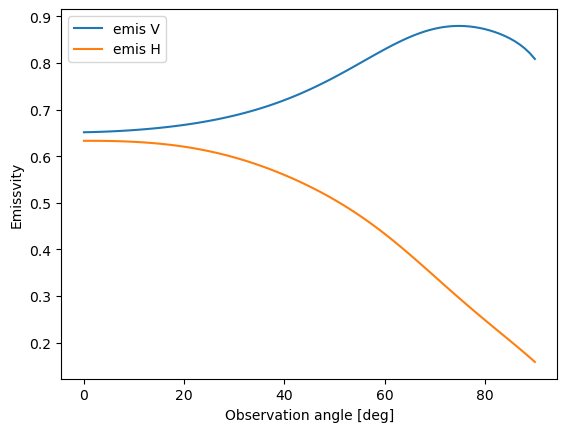

In [4]:

frequency=100 #in GHz
obs_angle=np.linspace(0,90,91)
windspeed=7
temperature=283
salinity=0.0036

xx=np.tile([frequency*1e+9,obs_angle[0],windspeed,temperature,salinity ],(len(obs_angle),1))
for i in range(len(obs_angle)):
    xx[i,1]=obs_angle[i]


emv=tessemNN1(xx,netV)

emh=tessemNN1(xx,netH)

plot_emis(emv,emh,obs_angle)

Moving to sea ice we need to define a funciton to calculate the sea ice emissivity, we will use some empirical formulas from a 1999 study (see code comments for details).

In [5]:
def hewison_snow(ikind,theta,ni):
#    subroutine to calculate microwave emissivity for snow from model:
#    T.J.Hewison and S.J.English 1999: Airborne Retrievals of Snow and Ice Surface Emissivity at 
#    Millimetre Wavelengths. IEEE Trans. Geosci.Remote Sensing, Vol.37, No.4, 1999, pp.1871-1879, 
#    doi:10.1109/36.774700. 
 
#    theta is the incidence angle in degrees
#    ni is frequency in GHz
#    ev and eh are the emissivities vertical and horizontal polarized
#    ikind is the category of snow:
 
#    grease ice			1
#    Baltic Nilas		2
#    bare new Ice		3
#    New ice + snow		4
#    Broken Ice			5
#    Compact pack ice	6
#    Fast ice			7
#    lake Ice + Snow	8
#    First year Ice		9
#    Deep dry Snow		10
#    forest +snow		11
#    fresh Wet Snow		12

    
    aes=np.array([ 23.7,1.6,2.86,2.18,3.03,2.04,1.66,1.78,1.52,3.02,2.95,2.22])
    aein=np.array([ 7.65,3.34,3.4,3.7,5.47,1.7E+6,77.8,67.1,84.5E+3,24.0,5.08,109.0])
    anig=np.array([ 17.3,2.18,27.0,122.,183.,50.E+6,703.,534.,4.7E+6,59.9,64.,45.E+3])
    asigma=np.array([ 0.,0.,0.,0.,0.,0.,0.1,0.1,0.,0.1,0.,0.])
    aQ=np.array([  0.,0.15,0.,0.,0.15,0.,0.,0.35,0.15,0.,0.40,0.])
  

    es=aes[ikind]
    ein=aein[ikind]
    nig=anig[ikind]
    sigma=asigma[ikind]
    Q=aQ[ikind]

    k1=np.array([1-1j*(ni/nig)])
    rperm=(es-ein)/k1+ein
    thetarad=theta*np.pi/180


    n1=1.
    n2=rperm
    sintheta2=(np.sin(thetarad))**2
    coef=np.emath.sqrt(rperm-sintheta2)

    cc=np.cos(thetarad)

    crefV=((-n2*cc + coef)/(n2*cc + coef))
    crefH=(( n1*cc - coef)/(n1*cc + coef))
    
    refV=np.real(crefV)*np.real(crefV)+np.imag(crefV)*np.imag(crefV)
    refH=np.real(crefH)*np.real(crefH)+np.imag(crefH)*np.imag(crefH)

    refV1=(1.-Q)*refV+Q*refH
    refH1=(1.-Q)*refH+Q*refV


    h1=(4*np.pi*ni*sigma/300.)**2
    ev=1.-refV1*np.exp(-h1*(cc**2))
    eh=1.-refH1*np.exp(-h1*(cc**2))
    return ev,eh
    

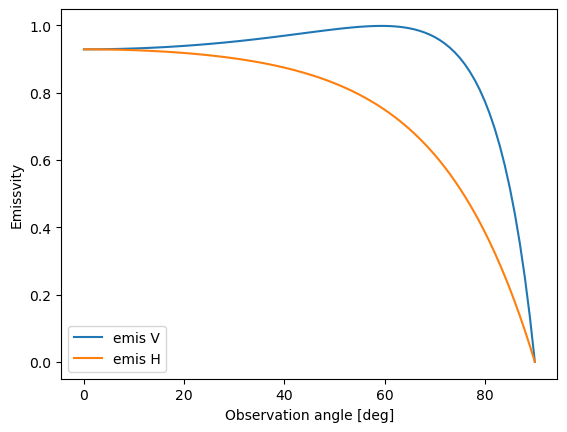

In [6]:
[ice_ev,ice_eh]=hewison_snow(3,obs_angle,100)
plot_emis(ice_ev,ice_eh,obs_angle)

now we only need to plot all toghether

In [7]:
def plot_emis2(oc_ev,oc_eh,ice_ev,ice_eh,obs_angle):
    import matplotlib.pyplot as plt
    # plot lines
    plt.plot(obs_angle, oc_ev, '-b',label = "emis V Oc")
    plt.plot(obs_angle, oc_eh, '--b',label = "emis H Oc")
    
    plt.plot(obs_angle, ice_ev, '-r',label = "emis V Ice")
    plt.plot(obs_angle, ice_eh, '--r',label = "emis H Ice")
    
    plt.legend()
    plt.xlabel('Observation angle [deg]')
    plt.ylabel('Emissvity')
    plt.show()

now all in one cell of code:

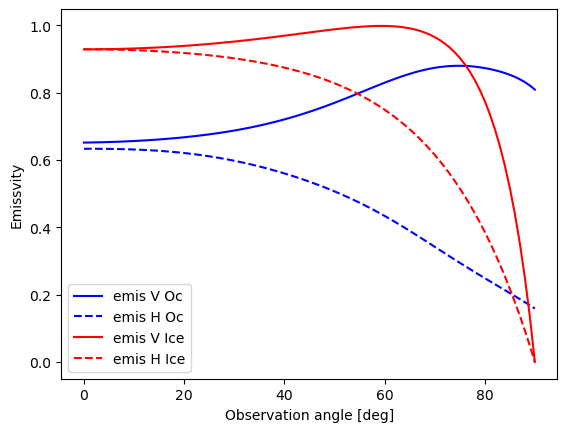

In [14]:
frequency=100 #in GHz
obs_angle=np.linspace(0,90,91)
windspeed=7
temperature=283
salinity=0.0036

xx=np.tile([frequency*1e+9,obs_angle[0],windspeed,temperature,salinity ],(len(obs_angle),1))
for i in range(len(obs_angle)):
    xx[i,1]=obs_angle[i]


oc_ev=tessemNN1(xx,netV)
oc_eh=tessemNN1(xx,netH)
[ice_ev,ice_eh]=hewison_snow(3,obs_angle,100)

plot_emis2(oc_ev,oc_eh,ice_ev,ice_eh,obs_angle)

now try to answer to the question raised on the starting of this notebook:

**what combination of angle of observation, polarization and frequency from a microwave radiometer should better discriminate between sea ice and free of ice ocean?** 

You should modify the code in the last cell consider a frequency range between 4 and 200 GHz, observation angles between 0 and 90° and any combination of V and H polarization. Leaving Wind, salinity and temperature to the initial values (Wind = 7 m/s, Temperature = 283 K and salinity = 0.0036)


Now try to modify the wind speed (between 0-25 m/s), Surface Temperature (270-310 K)

**How your result is modified?**
 

Another question:
**if instead of a radiometer you are using a radar, what would be the perfect frequency, polarization and observation angle for the same purpose (discriminating ssea ice from ocean)?**
